<center><b>ASSIGNMENT 3
    
<center>Julia Lascar

PROBLEM 1)

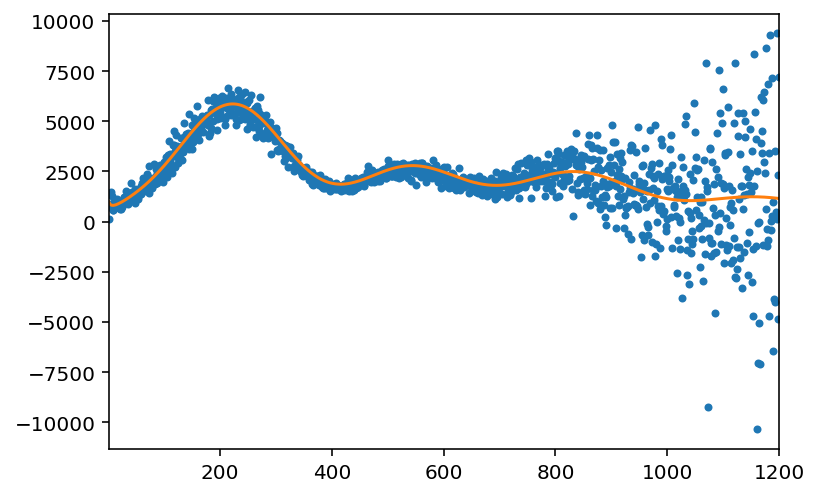

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import pyplot as plt
import time
import camb


def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('/Users/jmlascar/wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

axes = plt.gca()
axes.set_xlim([2,1200])

cmb=get_spectrum(pars)
cmb_cut=cmb[2:1199+2]
plt.plot(cmb_cut)
chisq=np.sum((cmb_cut-wmap[:,1])**2/(wmap[:,2])**2)
print(chisq)


<b>Problem 2)

newton loop  0
Chi squared changes by 0.0
newton loop  1
Chi squared changes by 352.58467603179156
newton loop  2
Chi squared changes by 7.715028504631164
newton loop  3
Chi squared changes by 0.0017169059615298465
newton loop  4
Chi squared changes by 6.537464946632099e-05
Our best guess of parameters is  [6.92896291e+01 2.24894300e-02 1.14007295e-01 2.04315934e-09
 9.69664433e-01]


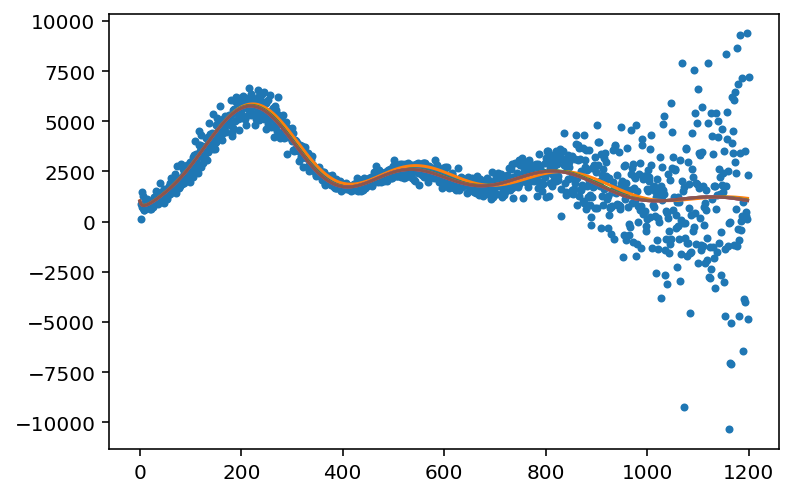

In [50]:
%matplotlib inline
plt.plot(wmap[:,0],wmap[:,1],'.')
def get_spectrum_tau(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    As=pars[3]
    ns=pars[4]
    tau=0.05
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,tau=tau,mnu=0.06,omk=0)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


def get_derivs_tau(f,pars):
    df=np.zeros((1199,len(pars)))
    dx=[0.1,0.001,0.01,1e-10,0.01]
    add=np.zeros(len(pars))
    for i in range(len(pars)):
            d=1/(2*dx[i])
            add[i]=dx[i]
            df[:,i]=(f(pars+add)[2:1201]-f(pars-add)[2:1201])*d
            add=np.zeros(len(pars))
    return df

pars=np.asarray([65,0.02,0.1,2e-9,0.96])
y=wmap[:,1]
guess=cmb_cut.copy()

chi_old=np.sum((cmb_cut-wmap[:,1])**2/(wmap[:,2])**2)
chi_thresh=0.01
L=0.001
for i in range(5):
    print("newton loop ",i)
    pars_old=pars.copy()
    guess2 = get_spectrum_tau(pars)
    plt.plot(guess2[2:1201])
    cmb_cut=guess2[2:1201]
    derivs=get_derivs_tau(get_spectrum_tau,pars)
    
    resid = y-cmb_cut #residual
    N=np.diag(wmap[:,2]**2) #noise
    #solving for Am^T.N^-1.Am.dm=Am^TN^-1r
    AN=np.dot(np.transpose(derivs),np.linalg.inv(N)) 
    rhs=np.dot(AN,derivs)
    lhs=np.dot(AN,resid)
    dm=np.dot(np.linalg.inv(rhs),lhs)
    chi_new = np.sum((resid**2)/(wmap[:,2]**2))
    pars = pars_old+dm
    print("Chi squared changes by",chi_old-chi_new)
    chi_old = chi_new
    #covariance matrix: diagonal, has the errors^2 in the diag: 
    mycov=np.linalg.inv(rhs)
          
newton_pars= pars
newton_guess = get_spectrum_tau(newton_pars)
print("Our best guess of parameters is ",pars)
plt.show()


In [7]:
mycov=error #this is our covariance matrix
Err=np.sqrt(np.diag(mycov))
print(Err)

[2.41779161e+00 5.39798695e-04 5.24915876e-03 3.92726671e-11
 1.36022901e-02]


The errors from our analysis for a parameter P is of the order of Pe-2. 
If we were to keep tau floating, we can estimate that the errors would be roughly the same and that the error for tau would be about 0.0005. 

In [21]:
err_tau= [2.41779161e+00,5.39798695e-04,5.24915876e-03,0.0005,3.92726671e-11,1.36022901e-02]
#now to get our covariance matrix
covmat=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        covmat[i,j]=err_tau[i]*err_tau[j]


[[5.84571627e+00 1.30512076e-03 1.26913720e-02 1.20889581e-03
  9.49531250e-11 3.28875029e-02]
 [1.30512076e-03 2.91382631e-07 2.83348905e-06 2.69899348e-07
  2.11993344e-14 7.34249844e-06]
 [1.26913720e-02 2.83348905e-06 2.75536677e-05 2.62457938e-06
  2.06148465e-13 7.14005802e-05]
 [1.20889581e-03 2.69899348e-07 2.62457938e-06 2.50000000e-07
  1.96363336e-14 6.80114505e-06]
 [9.49531250e-11 2.11993344e-14 2.06148465e-13 1.96363336e-14
  1.54234238e-21 5.34198211e-13]
 [3.28875029e-02 7.34249844e-06 7.14005802e-05 6.80114505e-06
  5.34198211e-13 1.85022296e-04]]
0.001305120755859949


<b>Problem 3)

In [75]:
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

def get_step(step_size):
    step = np.random.randn(len(step_size))*step_size
    return step

step_size = np.array([0.1, 1e-04, 1e-03, 0.001, 1e-11,
 1e-02])
pars = []
pars.append([65,0.02,0.1,0.05,2e-9,0.96])
x=wmap[:,0]
y=wmap[:,1]
noise=wmap[:,2]
chisq = []
model=get_spectrum(pars[0])
chisq.append(get_chisq(y,model[2:1201],noise))
print(chisq)
print(pars)

nstep = 500
steps_taken = 0
while steps_taken < nstep:
    
    # Update our parameters
    new_pars = pars[-1] + get_step(step_size)
    new_y = get_spectrum(new_pars)[2:1201]
    new_chisq = get_chisq(y, new_y, noise)
    
    # Calculate ΔΧ^2
    Δ_chisq = new_chisq - chisq[-1]
    prob_step = np.exp(-0.5*Δ_chisq)
    
    
    if new_pars[3] >= 0:
        accept = np.random.rand(1) < prob_step
        if accept:
            pars.append(new_pars)
            chisq.append(new_chisq)
            steps_taken += 1
            print(steps_taken)


[1588.2376465826746]
[[65, 0.02, 0.1, 0.05, 2e-09, 0.96]]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

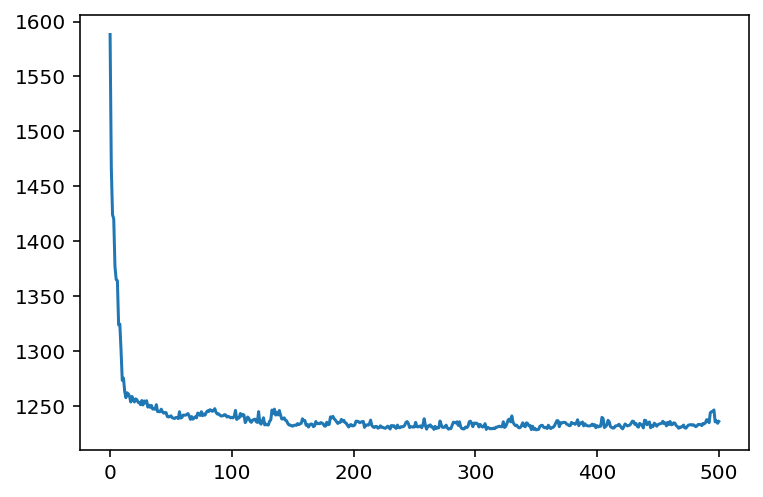

In [77]:
#the numbers before were just to keep track of the chain's progress.
plt.plot(chisq)



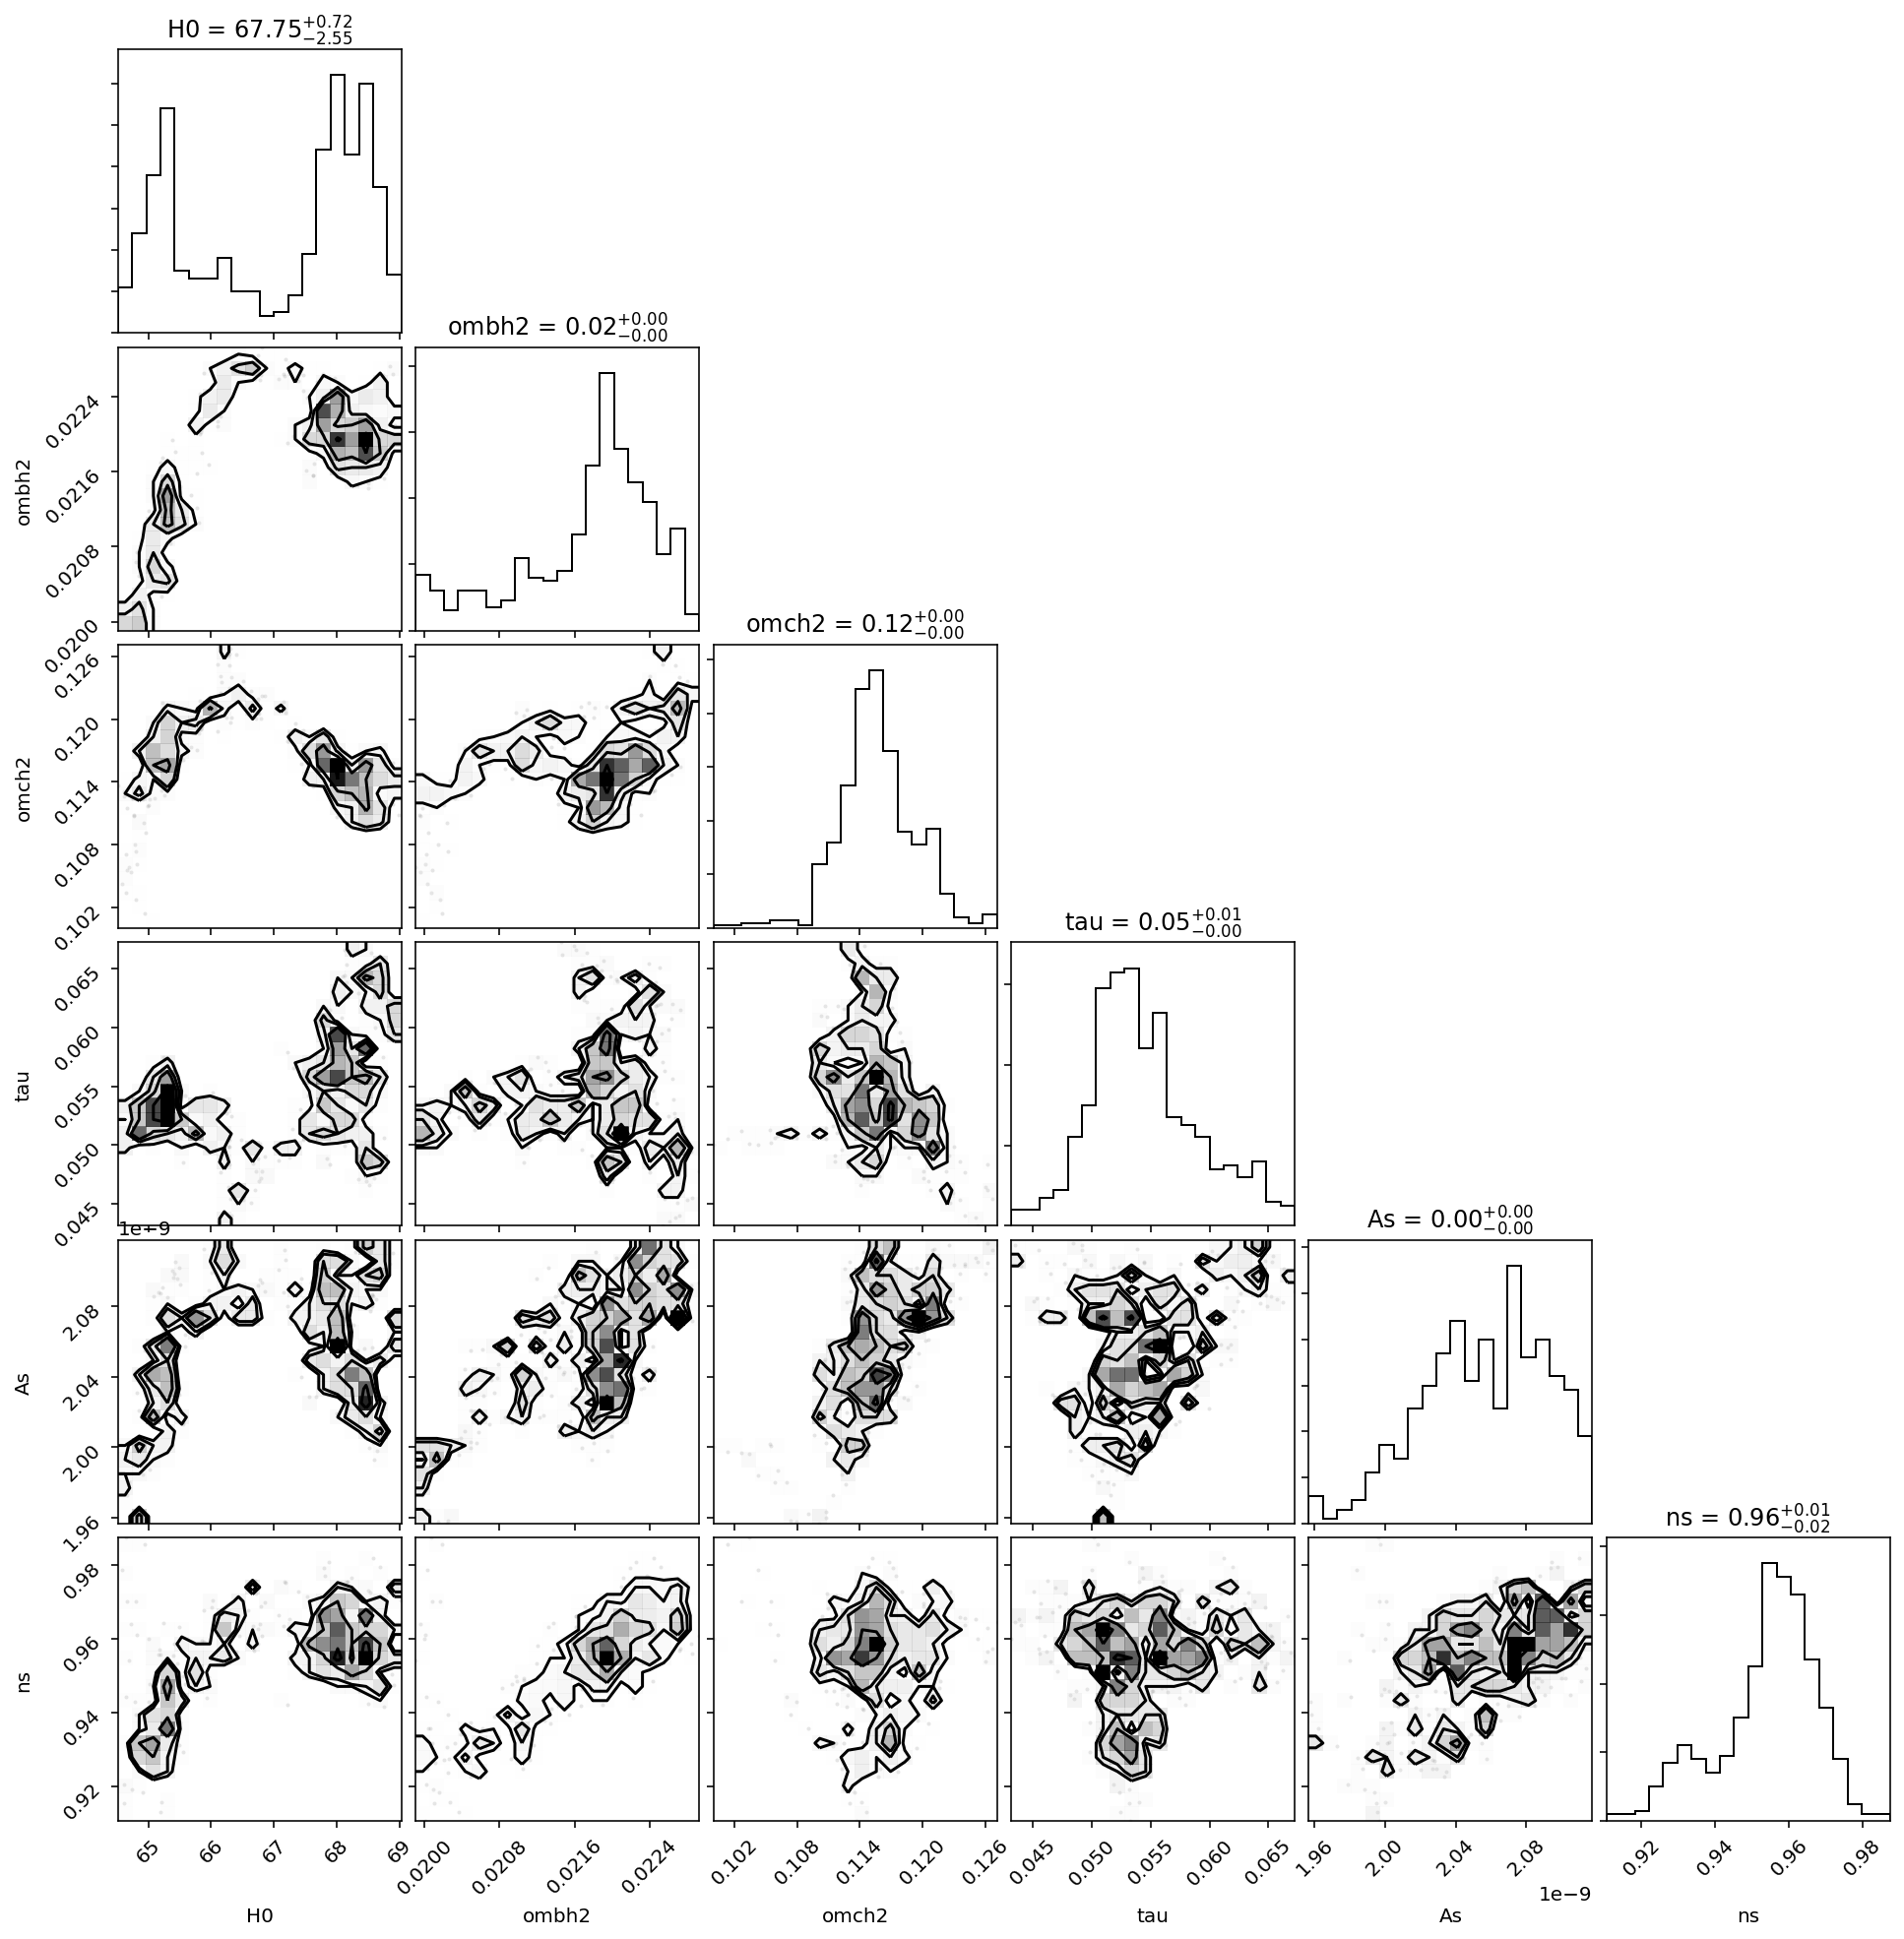

In [78]:
import corner
pars = np.array(pars)
corner.corner(pars,labels=["H0","ombh2","omch2","tau","As","ns"],show_titles=True,title_fmt='.2f')
plt.show()


In [ ]:
#(This would probably get better results with a higher nstep, 
#but I don't have time to run a longer chain right now)

<b>Problem 4)

In [81]:
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

def get_step(step_size):
    step = np.random.randn(len(step_size))*step_size
    return step

step_size = np.array([0.1, 1e-04, 1e-03, 0.0073, 1e-11,
 1e-02])
pars = []
pars.append([65,0.02,0.1,0.544,2e-9,0.96])
x=wmap[:,0]
y=wmap[:,1]
noise=wmap[:,2]
chisq = []
model=get_spectrum(pars[0])
chisq.append(get_chisq(y,model[2:1201],noise))
print(chisq)
print(pars)

nstep = 500
steps_taken = 0
while steps_taken < nstep:
    
    # Update our parameters
    new_pars = pars[-1] + get_step(step_size)
    new_y = get_spectrum(new_pars)[2:1201]
    new_chisq = get_chisq(y, new_y, noise)
    
    # Calculate ΔΧ^2
    Δ_chisq = new_chisq - chisq[-1]
    prob_step = np.exp(-0.5*Δ_chisq)
    
    
    if new_pars[3] >= 0:
        accept = np.random.rand(1) < prob_step
        if accept:
            pars.append(new_pars)
            chisq.append(new_chisq)
            steps_taken += 1
            print(steps_taken)



[27397.71611977931]
[[65, 0.02, 0.1, 0.544, 2e-09, 0.96]]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

KeyboardInterrupt: 

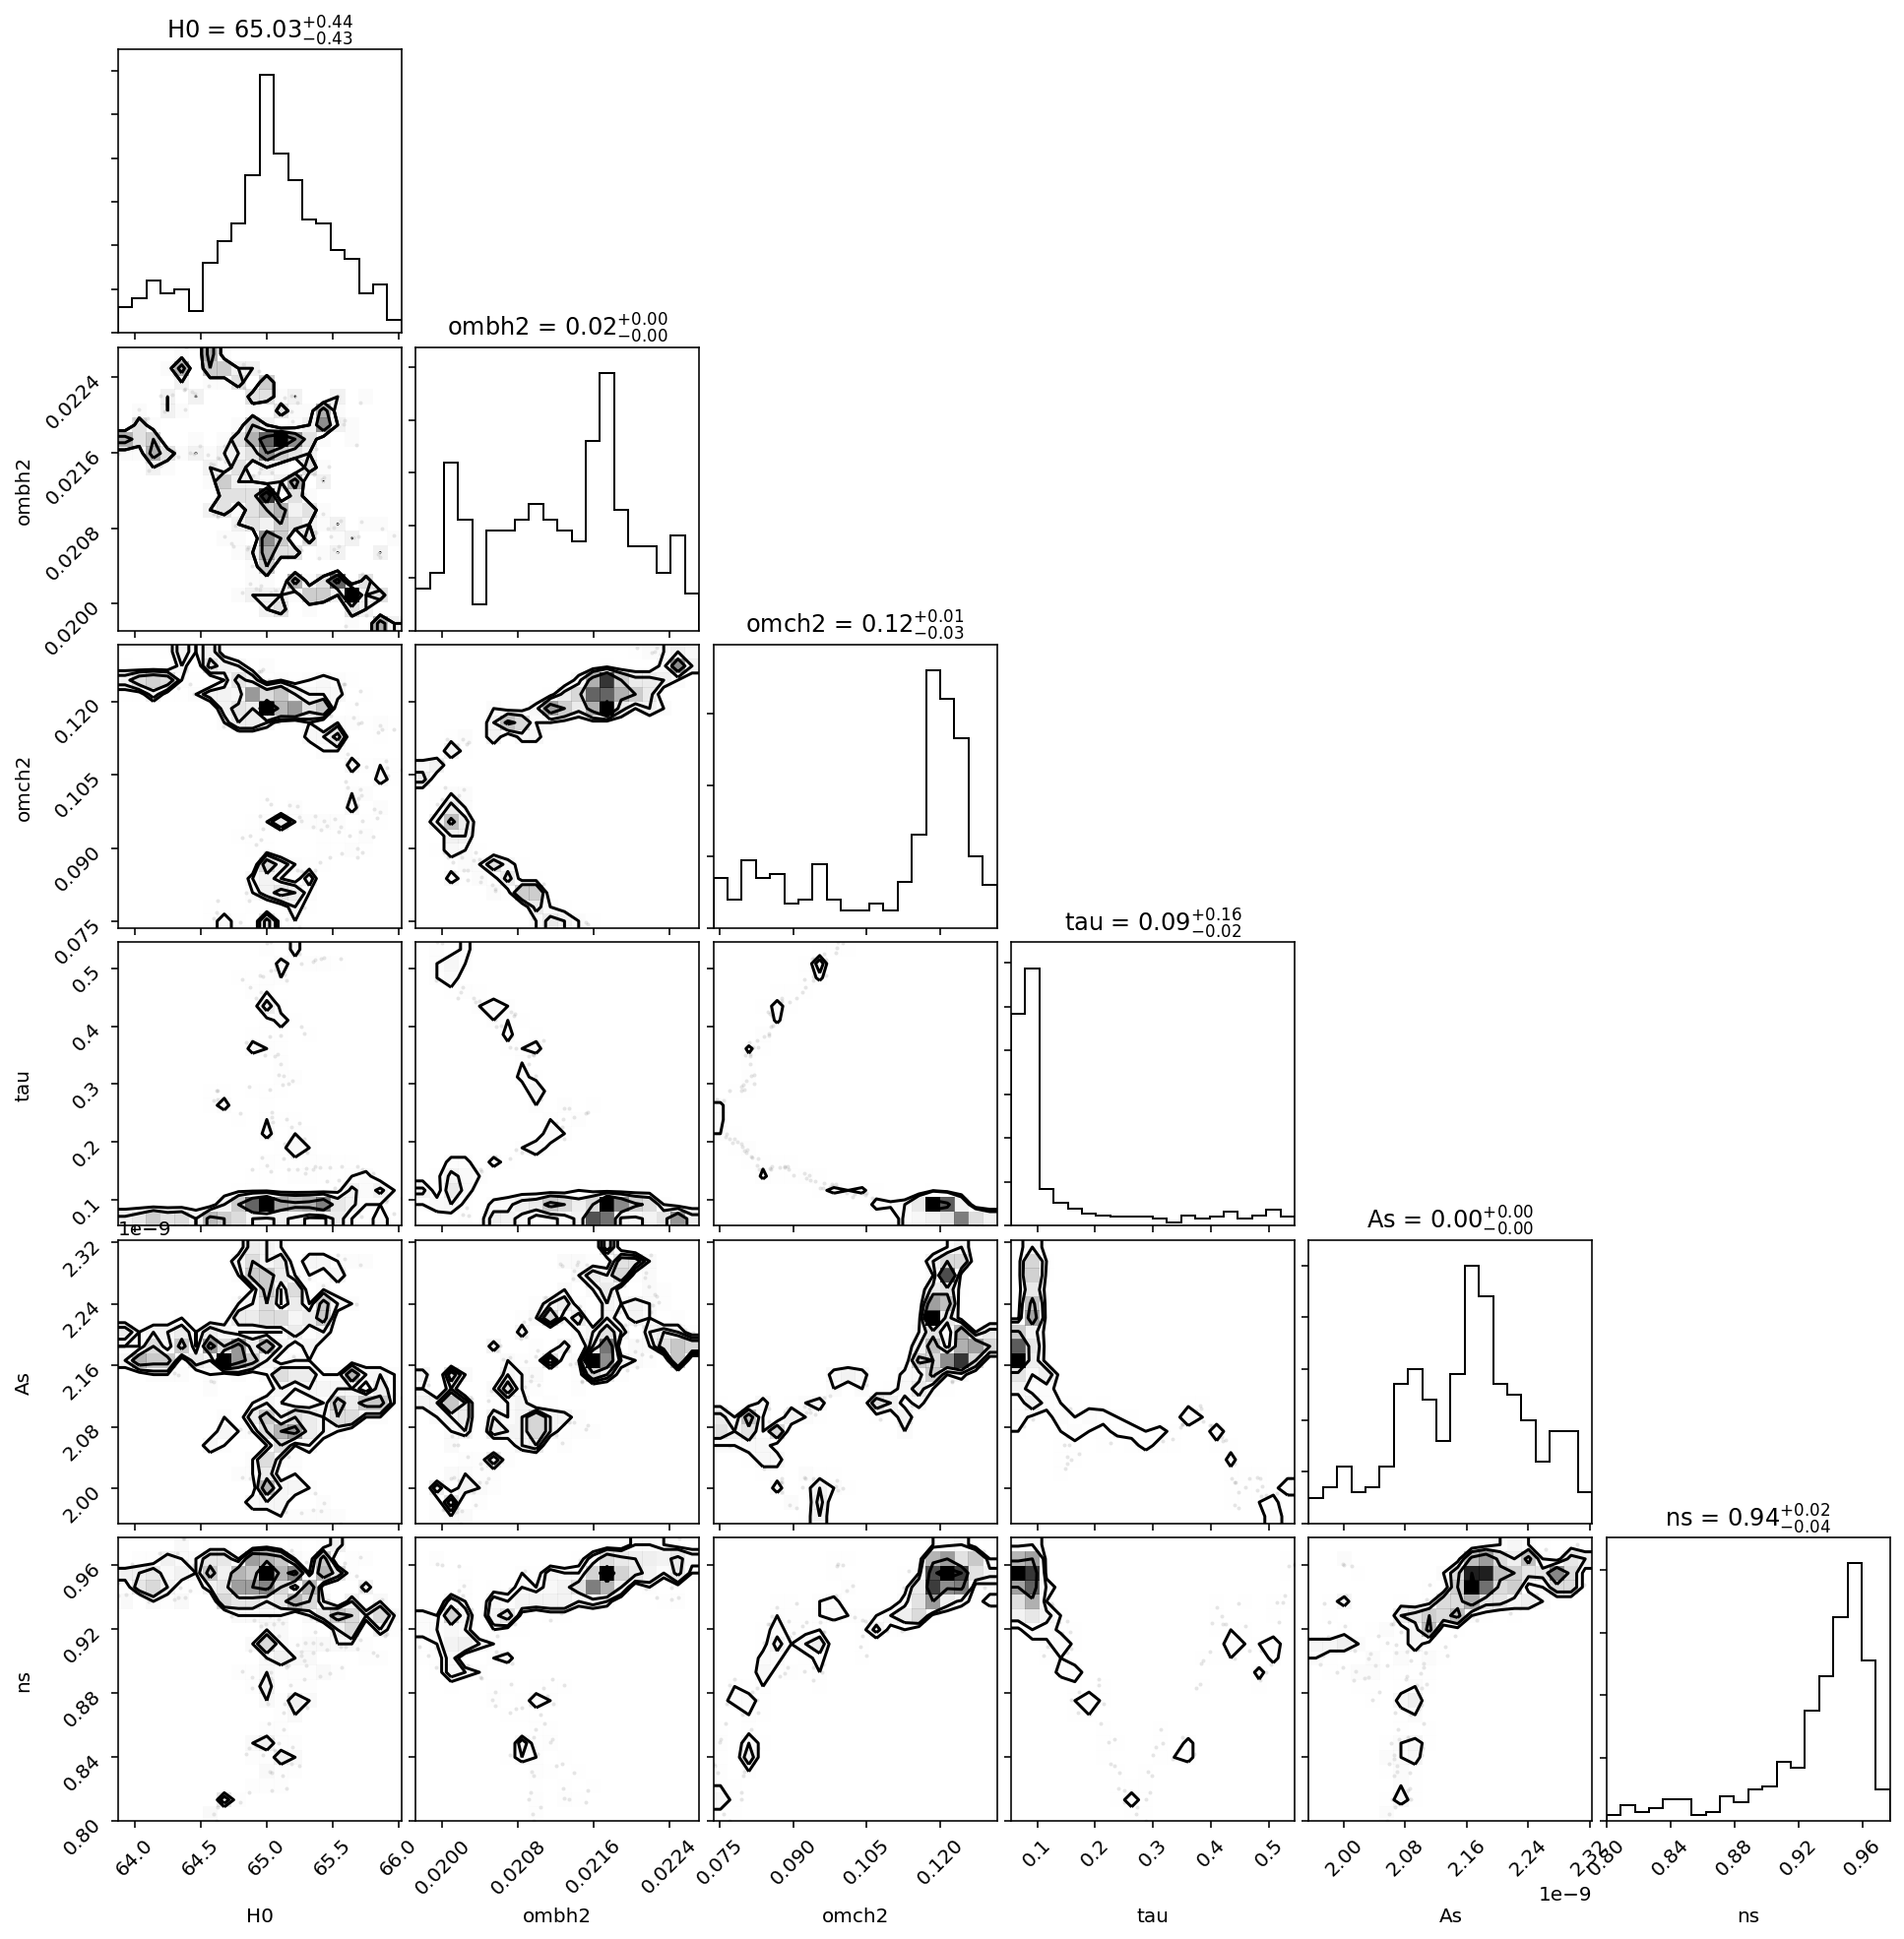

In [82]:
#the numbers before were just to keep track of the chain's progress.
pars = np.array(pars)
corner.corner(pars,labels=["H0","ombh2","omch2","tau","As","ns"],show_titles=True,title_fmt='.2f')
plt.show()